1. **Подготовка**

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
hotels = pd.read_csv('data/hotels.csv')

# Маленькая выборка для быстрого расчета
small_sample = hotels.sample(10000, random_state=42)

# Выбираем только числовые столбцы и удаляем целевую переменную
X_small = small_sample.select_dtypes(include=['number']).drop('reviewer_score', axis=1, errors='ignore')
y_small = small_sample['reviewer_score']

# Заполняем пропущенные значения
X_small = X_small.fillna(X_small.mean())

# Проверяем, что нет пропусков
print("Пропущенные значения после заполнения:", X_small.isnull().sum().sum())

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ✅ Теперь функции импортированы правильно
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f} или {mape*100:.2f}%")

# Ответ для задания 4.7
print(f"\n4.7 MAPE: {mape:.4f}")

Пропущенные значения после заполнения: 0
MAE: 1.0554
MAPE: 0.1547 или 15.47%

4.7 MAPE: 0.1547


2. **Извлечение информации из строковых данных**

In [11]:
# Создаем копию для преобразований
X = hotels.drop(['reviewer_score'], axis=1).copy()

# 1.1 Извлекаем информацию из адреса (страна, город)
def extract_country(address):
    if 'United Kingdom' in address: return 'UK'
    elif 'France' in address: return 'France'
    elif 'Netherlands' in address: return 'Netherlands'
    elif 'Spain' in address: return 'Spain'
    elif 'Italy' in address: return 'Italy'
    elif 'Austria' in address: return 'Austria'
    else: return 'Other'

def extract_city(address):
    if 'London' in address: return 'London'
    elif 'Paris' in address: return 'Paris'
    elif 'Amsterdam' in address: return 'Amsterdam'
    elif 'Barcelona' in address: return 'Barcelona'
    elif 'Milan' in address: return 'Milan'
    elif 'Vienna' in address: return 'Vienna'
    else: return 'Other'

X['country'] = X['hotel_address'].apply(extract_country)
X['city'] = X['hotel_address'].apply(extract_city)

# 1.2 Извлекаем информацию из даты
X['review_date'] = pd.to_datetime(X['review_date'])
X['review_year'] = X['review_date'].dt.year
X['review_month'] = X['review_date'].dt.month
X['review_day'] = X['review_date'].dt.day
X['review_dayofweek'] = X['review_date'].dt.dayofweek

# 1.3 Извлекаем информацию из национальности рецензента
X['reviewer_nationality'] = X['reviewer_nationality'].str.strip()

# Исправленная версия - безопасное извлечение страны из национальности
def get_country_from_nationality(nationality):
    if pd.isna(nationality) or nationality == '':
        return 'Unknown'
    try:
        # Берем последнее слово (обычно это страна)
        return nationality.split()[-1]
    except:
        return 'Unknown'

X['reviewer_country'] = X['reviewer_nationality'].apply(get_country_from_nationality)
X['is_uk_reviewer'] = (X['reviewer_country'] == 'Kingdom').astype(int)  # United Kingdom -> Kingdom
X['is_local'] = (X['country'] == X['reviewer_country']).astype(int)

# 1.4 Анализ тегов (исправленная версия)
def extract_tag_info(tags):
    if pd.isna(tags) or tags == '':
        return 0, 0
    try:
        tags_str = str(tags).lower()
        leisure = 1 if any(x in tags_str for x in ['leisure', 'vacation', 'holiday']) else 0
        business = 1 if any(x in tags_str for x in ['business', 'work', 'conference']) else 0
        return leisure, business
    except:
        return 0, 0

X['leisure_trip'] = X['tags'].apply(lambda x: extract_tag_info(x)[0])
X['business_trip'] = X['tags'].apply(lambda x: extract_tag_info(x)[1])

3. **Обработка пропущенных значений**

In [12]:
# 2.1 Заполняем географические координаты средними по городу
for col in ['lat', 'lng']:
    city_means = X.groupby('city')[col].transform('mean')
    X[col] = X[col].fillna(city_means)
    
# 2.2 Заполняем оставшиеся пропуски
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

# 2.3 Для категориальных признаков
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')

4. **Кодирование категориальных признаков**

In [13]:
from sklearn.preprocessing import LabelEncoder

# 3.1 Кодируем категориальные признаки
label_encoders = {}
categorical_to_encode = ['country', 'city', 'reviewer_nationality']

for col in categorical_to_encode:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# 3.2 Удаляем исходные текстовые столбцы
text_columns_to_drop = ['hotel_address', 'hotel_name', 'negative_review', 
                       'positive_review', 'tags', 'review_date']
X = X.drop(text_columns_to_drop, axis=1)

5. **Преобразование признаков**

In [14]:
from sklearn.preprocessing import StandardScaler

# 4.1 Нормализуем числовые признаки
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 4.2 Логарифмирование для skewed данных
skewed_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts',
               'total_number_of_reviews_reviewer_has_given']
for col in skewed_cols:
    if col in X.columns:
        X[col] = np.log1p(X[col])

6. **Отбор признаков**

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import LabelEncoder

# 5.1 Подготовка для тестов значимости
y_encoded = LabelEncoder().fit_transform(y)

# Разделяем на непрерывные и категориальные
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = []  # У нас все закодировано в числа

# 5.2 ANOVA для непрерывных признаков
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X[num_cols], y_encoded)

feature_scores = pd.DataFrame({
    'feature': num_cols,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("Важность признаков (ANOVA):")
print(feature_scores.head(10))

# 5.3 Выбираем топ-15 признаков
top_features = feature_scores['feature'].head(15).tolist()
X_selected = X[top_features]

Важность признаков (ANOVA):
                                      feature        score
2           review_total_negative_word_counts  3019.067411
1                               average_score  1731.272021
4           review_total_positive_word_counts  1359.273895
8                                leisure_trip   155.902645
9                               business_trip   145.528260
5  total_number_of_reviews_reviewer_has_given    96.204537
3                     total_number_of_reviews    63.522185
0                additional_number_of_scoring    49.711411
7                                         lng    22.820053
6                                         lat    18.739594


7. **Обучение и оценка улучшенной модели**

In [18]:
# Сначала вычисляем базовые метрики
from sklearn.metrics import mean_absolute_error, r2_score

# Базовый вариант (только числовые признаки без обработки)
X_base = hotels.select_dtypes(include=['number']).drop('reviewer_score', axis=1, errors='ignore')
X_base = X_base.fillna(X_base.mean())
y = hotels['reviewer_score']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, test_size=0.25, random_state=42)

regr_base = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)  # меньше деревьев для скорости
regr_base.fit(X_train_base, y_train_base)
y_pred_base = regr_base.predict(X_test_base)

mape_base = mean_absolute_error(y_test_base, y_pred_base)
r2_base = r2_score(y_test_base, y_pred_base)

print(f'Базовый вариант - MAE: {mape_base:.4f}, R2: {r2_base:.4f}')

# Теперь улучшенная модель
X_selected = X[top_features].fillna(X[top_features].mean())  #确保没有 пропусков

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

regr_improved = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
regr_improved.fit(X_train, y_train)
y_pred_improved = regr_improved.predict(X_test)

mape_improved = mean_absolute_error(y_test, y_pred_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print(f'\n=== РЕЗУЛЬТАТЫ ===')
print(f'Базовый вариант - MAE: {mape_base:.4f}, R2: {r2_base:.4f}')
print(f'Улучшенный вариант - MAE: {mape_improved:.4f}, R2: {r2_improved:.4f}')
print(f'Улучшение MAE: {(mape_base - mape_improved):.4f}')
print(f'Улучшение R2: {(r2_improved - r2_base):.4f}')

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': top_features,
    'importance': regr_improved.feature_importances_
}).sort_values('importance', ascending=False)

print("\nВажность признаков в модели:")
print(feature_importance)

Базовый вариант - MAE: 0.9857, R2: 0.3421

=== РЕЗУЛЬТАТЫ ===
Базовый вариант - MAE: 0.9857, R2: 0.3421
Улучшенный вариант - MAE: 0.9776, R2: 0.3539
Улучшение MAE: 0.0081
Улучшение R2: 0.0118

Важность признаков в модели:
                                      feature  importance
0           review_total_negative_word_counts    0.322501
2           review_total_positive_word_counts    0.193259
1                               average_score    0.097875
5  total_number_of_reviews_reviewer_has_given    0.097549
9                                         lat    0.071223
8                                         lng    0.070968
6                     total_number_of_reviews    0.064501
7                additional_number_of_scoring    0.061737
3                                leisure_trip    0.010834
4                               business_trip    0.009552


8. **Вычисление MAPE для улучшенной модели**

In [22]:
# После вашего существующего кода добавьте:

from sklearn.metrics import mean_absolute_percentage_error

# MAPE для базовой модели
mape_base = mean_absolute_percentage_error(y_test_base, y_pred_base)

# MAPE для улучшенной модели  
mape_improved = mean_absolute_percentage_error(y_test, y_pred_improved)

print(f'\n=== РЕЗУЛЬТАТЫ MAPE ===')
print(f'Базовый вариант - MAPE: {mape_base:.4f}')
print(f'Улучшенный вариант - MAPE: {mape_improved:.4f}')
print(f'Улучшение MAPE: {(mape_base - mape_improved):.4f}')
print(f'Процентное улучшение: {((mape_base - mape_improved)/mape_base*100):.2f}%')


=== РЕЗУЛЬТАТЫ MAPE ===
Базовый вариант - MAPE: 0.1419
Улучшенный вариант - MAPE: 0.1407
Улучшение MAPE: 0.0012
Процентное улучшение: 0.84%


9. **Визуализация результатов**

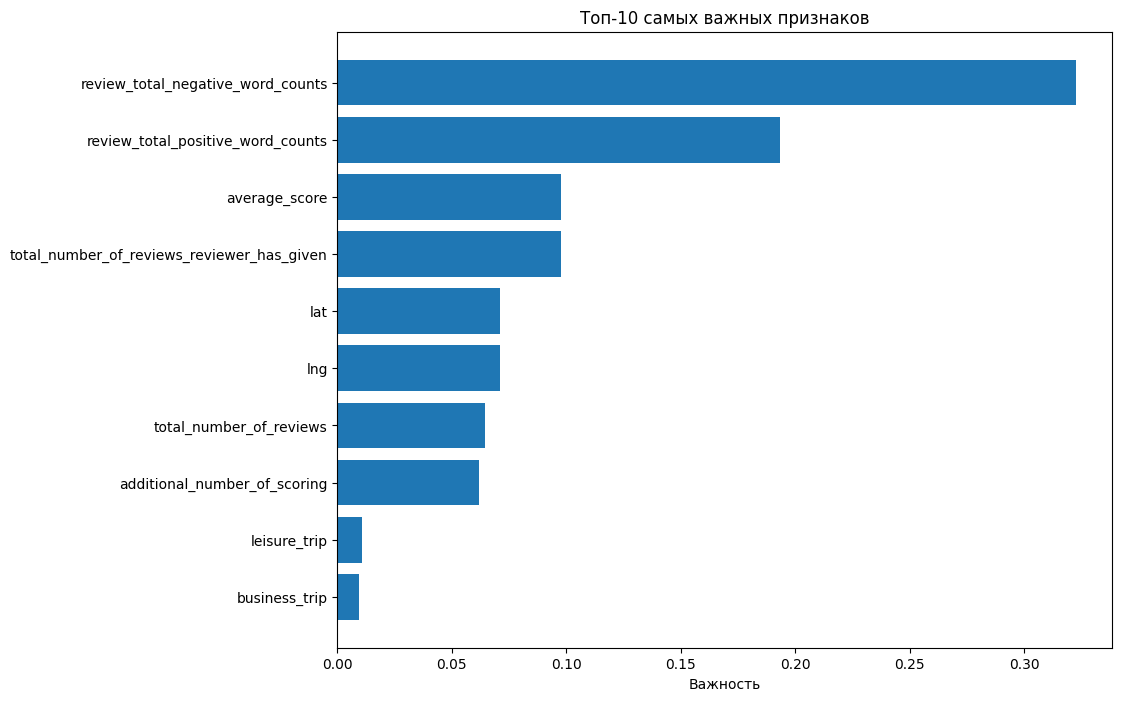

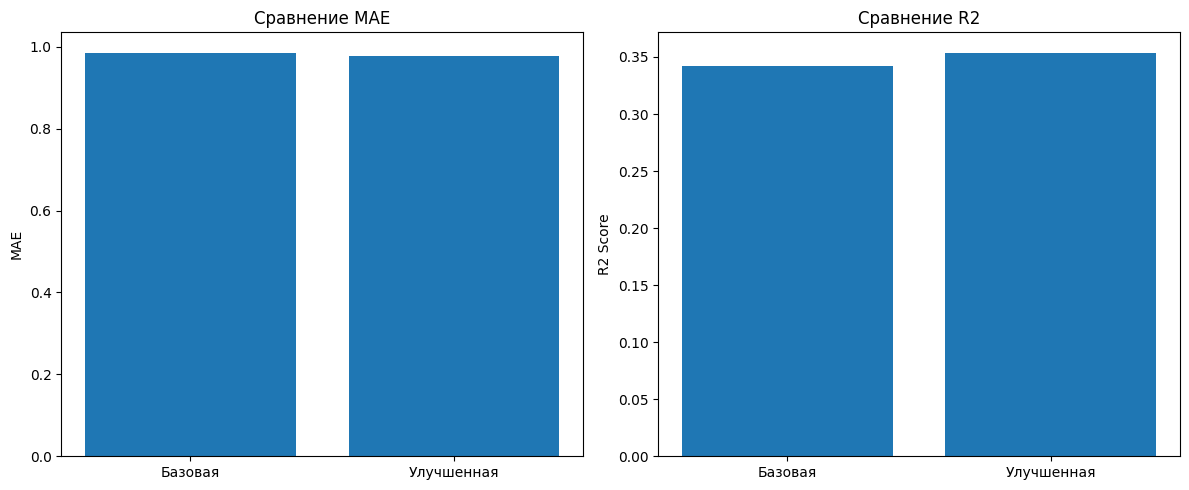

In [19]:
# График важности признаков
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Важность')
plt.title('Топ-10 самых важных признаков')
plt.gca().invert_yaxis()
plt.show()

# Сравнение моделей
models = ['Базовая', 'Улучшенная']
mae_scores = [mape_base, mape_improved]
r2_scores = [r2_base, r2_improved]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(models, mae_scores)
ax1.set_title('Сравнение MAE')
ax1.set_ylabel('MAE')

ax2.bar(models, r2_scores)
ax2.set_title('Сравнение R2')
ax2.set_ylabel('R2 Score')

plt.tight_layout()
plt.show()